In [1]:
import rasterio


In [2]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from shapely.geometry import box
from shapely.ops import transform as shapely_transform
from pyproj import Transformer

# Function to reproject an image to a target CRS
def reproject_image(src, target_crs):
    transform, width, height = calculate_default_transform(
        src.crs, target_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': target_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open('/tmp/reprojected.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=target_crs,
                resampling=Resampling.nearest)
    return rasterio.open('/tmp/reprojected.tif')

# Open the two images
image1_path = r"D:\data4sasi\C2B060546_01021PS_20210929_DIP_ort.tif"
image2_path = r"D:\data4sasi\C2A072886_01021PS_20211029_DIP_ort.tif"

with rasterio.open(image1_path) as src1, rasterio.open(image2_path) as src2:
    # Reproject the second image to the CRS of the first image
    if src1.crs != src2.crs:
        src2 = reproject_image(src2, src1.crs)

    # Get the bounding boxes of both images
    bbox1 = box(*src1.bounds)
    bbox2 = box(*src2.bounds)

    # Find the intersection of the bounding boxes
    common_bbox = bbox1.intersection(bbox2)

    # Transform the intersection bounding box to the image's CRS
    transformer = Transformer.from_crs('EPSG:4326', src1.crs, always_xy=True)
    common_bbox = shapely_transform(transformer.transform, common_bbox)

    # Clip the images to the common bounding box
    common_window1 = rasterio.windows.from_bounds(*common_bbox.bounds, transform=src1.transform)
    common_window2 = rasterio.windows.from_bounds(*common_bbox.bounds, transform=src2.transform)

    # Read the common area from both images
    common_area1 = src1.read(window=common_window1)
    common_area2 = src2.read(window=common_window2)

    # Display or process the common area as needed
    print(f'Common area dimensions (image1): {common_area1.shape}')
    print(f'Common area dimensions (image2): {common_area2.shape}')


Common area dimensions (image1): (1, 16760, 12215)
Common area dimensions (image2): (1, 16551, 12063)


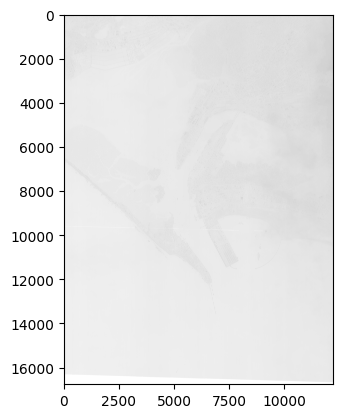

<Axes: >

In [3]:
from rasterio.plot import show
show(common_area1,cmap='binary')

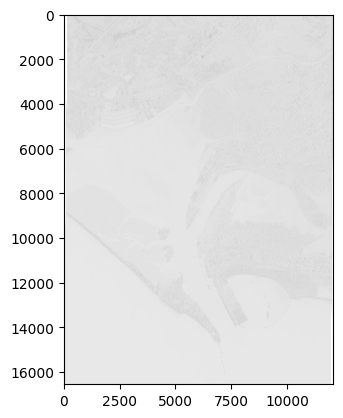

<Axes: >

In [4]:
show(common_area2,cmap="binary")

In [5]:
import rasterio
from rasterio.mask import mask
from shapely.geometry import box

# Function to get the intersection of bounding boxes
def get_common_bbox(src1, src2):
    bbox1 = box(*src1.bounds)
    bbox2 = box(*src2.bounds)
    common_bbox = bbox1.intersection(bbox2)
    return common_bbox

# Function to clip an image to a given bounding box
def clip_image_to_bbox(src, bbox):
    geom = [bbox.__geo_interface__]
    out_image, out_transform = mask(src, geom, crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})
    return out_image, out_meta

# Paths to the images
# image1_path = 'path/to/image1.tif'
# image2_path = 'path/to/image2.tif'

with rasterio.open(image1_path) as src1, rasterio.open(image2_path) as src2:
    # Check if the CRSs are the same
    if src1.crs != src2.crs:
        raise ValueError("CRS of the two images must be the same")

    # Get the common bounding box
    common_bbox = get_common_bbox(src1, src2)

    # Clip the images to the common bounding box
    common_area1, meta1 = clip_image_to_bbox(src1, common_bbox)
    common_area2, meta2 = clip_image_to_bbox(src2, common_bbox)

    print(f'Common area dimensions (image1): {common_area1.shape}')
    print(f'Common area dimensions (image2): {common_area2.shape}')


Common area dimensions (image1): (1, 16761, 12216)
Common area dimensions (image2): (1, 16551, 12063)


Common area dimensions (image1): (1, 16761, 12216)
Common area dimensions (image2): (1, 16551, 12063)


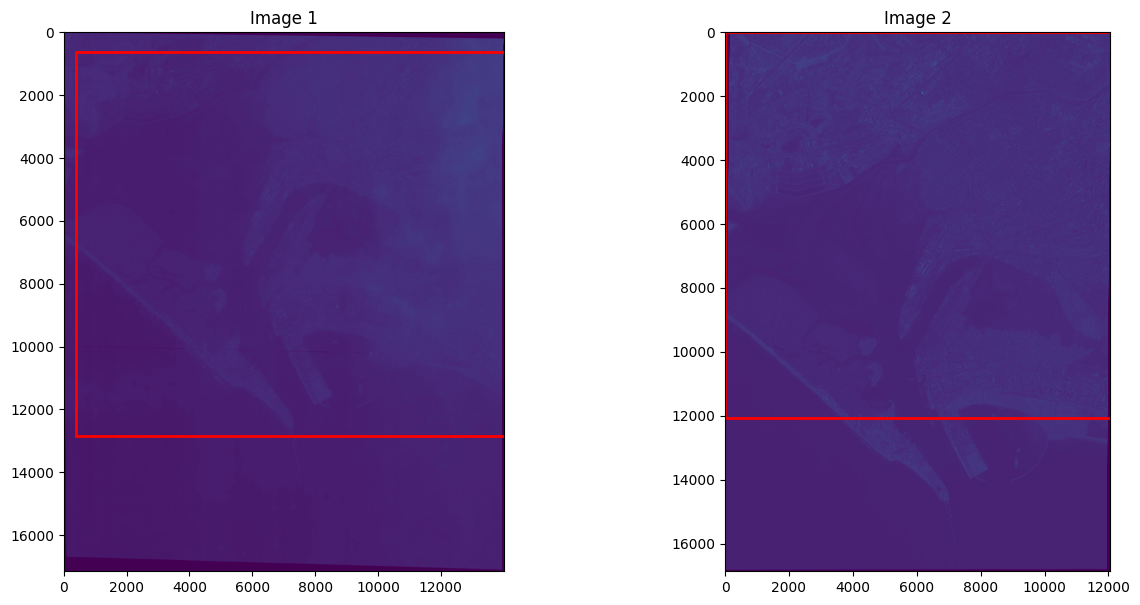

In [6]:
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
import matplotlib.pyplot as plt
import numpy as np

# Function to get the intersection of bounding boxes
def get_common_bbox(src1, src2):
    bbox1 = box(*src1.bounds)
    bbox2 = box(*src2.bounds)
    common_bbox = bbox1.intersection(bbox2)
    return common_bbox

# Function to clip an image to a given bounding box
def clip_image_to_bbox(src, bbox):
    geom = [bbox.__geo_interface__]
    out_image, out_transform = mask(src, geom, crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})
    return out_image, out_meta, out_transform

# Function to plot the images and draw a rectangle
def plot_images_with_rectangle(src1, src2, common_bbox):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    # Read and plot the first image
    image1 = src1.read(1)
    ax1.imshow(image1)
    ax1.set_title('Image 1')

    # Read and plot the second image
    image2 = src2.read(1)
    ax2.imshow(image2)
    ax2.set_title('Image 2')

    # Get the coordinates of the common bounding box
    minx, miny, maxx, maxy = common_bbox.bounds

    # Get pixel coordinates of the common bounding box for both images
    row_min_1, col_min_1 = ~src1.transform * (minx, miny)
    row_max_1, col_max_1 = ~src1.transform * (maxx, maxy)

    row_min_2, col_min_2 = ~src2.transform * (minx, miny)
    row_max_2, col_max_2 = ~src2.transform * (maxx, maxy)

    # Draw rectangles around the common area
    rect1 = plt.Rectangle((col_min_1, row_min_1), col_max_1 - col_min_1, row_max_1 - row_min_1,
                          linewidth=2, edgecolor='r', facecolor='none')
    rect2 = plt.Rectangle((col_min_2, row_min_2), col_max_2 - col_min_2, row_max_2 - row_min_2,
                          linewidth=2, edgecolor='r', facecolor='none')

    ax1.add_patch(rect1)
    ax2.add_patch(rect2)

    plt.show()

# Paths to the images
# image1_path = 'path/to/image1.tif'
# image2_path = 'path/to/image2.tif'

with rasterio.open(image1_path) as src1, rasterio.open(image2_path) as src2:
    # Check if the CRSs are the same
    if src1.crs != src2.crs:
        raise ValueError("CRS of the two images must be the same")

    # Get the common bounding box
    common_bbox = get_common_bbox(src1, src2)

    # Clip the images to the common bounding box
    common_area1, meta1, transform1 = clip_image_to_bbox(src1, common_bbox)
    common_area2, meta2, transform2 = clip_image_to_bbox(src2, common_bbox)

    print(f'Common area dimensions (image1): {common_area1.shape}')
    print(f'Common area dimensions (image2): {common_area2.shape}')

    # Plot the images with a rectangle around the common area
    plot_images_with_rectangle(src1, src2, common_bbox)


In [7]:
import rasterio
from rasterio.mask import mask
from shapely.geometry import box, mapping
import matplotlib.pyplot as plt

# Function to get the intersection of bounding boxes
def get_common_bbox(src1, src2):
    bbox1 = box(*src1.bounds)
    bbox2 = box(*src2.bounds)
    common_bbox = bbox1.intersection(bbox2)
    return common_bbox

# Function to clip an image to a given bounding box
def clip_image_to_bbox(src, bbox):
    geom = [mapping(bbox)]
    out_image, out_transform = mask(src, geom, crop=True)
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })
    return out_image, out_meta, out_transform

with rasterio.open(image1_path) as src1, rasterio.open(image2_path) as src2:
    # Check if the CRSs are the same
    if src1.crs != src2.crs:
        raise ValueError("CRS of the two images must be the same")

    # Get the common bounding box
    common_bbox = get_common_bbox(src1, src2)

    # Clip the images to the common bounding box
    common_area1, meta1, transform1 = clip_image_to_bbox(src1, common_bbox)
    common_area2, meta2, transform2 = clip_image_to_bbox(src2, common_bbox)

    print(f'Common area dimensions (image1): {common_area1.shape}')
    print(f'Common area dimensions (image2): {common_area2.shape}')



Common area dimensions (image1): (1, 16761, 12216)
Common area dimensions (image2): (1, 16551, 12063)


In [8]:
# image1_path=r"C:\Users\Azista Industries\OneDrive\Desktop\Tasks\Task\Images\Screenshot 2024-07-18 154019.png"
# image2_path=r"C:\Users\Azista Industries\OneDrive\Desktop\Tasks\Task\Images\Screenshot 2024-07-18 154549.png"

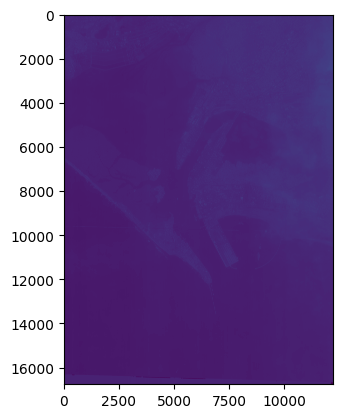

<Axes: >

In [27]:
import rasterio
from rasterio.plot import show
from rasterio.merge import merge
import matplotlib.pyplot as plt
import numpy as np

src1 = rasterio.open(image1_path)
src2 = rasterio.open(image2_path)



minx = max(src1.bounds.left, src2.bounds.left)
miny = max(src1.bounds.bottom, src2.bounds.bottom)
maxx = min(src1.bounds.right, src2.bounds.right)
maxy = min(src1.bounds.top, src2.bounds.top)
intersection_bounds = (minx, miny, maxx, maxy)

common, out_trans = merge([src1, src2], bounds=intersection_bounds)


show(common)



In [28]:
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
from rasterio.warp import transform_bounds
import cv2 as cv
def find_common_area(image1_path, image2_path, output_path):
    with rasterio.open(image1_path) as src1:
        image1_bounds = src1.bounds
        image1_crs = src1.crs
        
    with rasterio.open(image2_path) as src2:
        image2_bounds = src2.bounds
        image2_crs = src2.crs
        
    # Transform bounds to the same CRS
    if image1_crs != image2_crs:
        image2_bounds = transform_bounds(image2_crs, image1_crs, *image2_bounds)

    # Calculate intersection
    common_bounds = (
        max(image1_bounds.left, image2_bounds.left),
        min(image1_bounds.top, image2_bounds.top),
        min(image1_bounds.right, image2_bounds.right),
        max(image1_bounds.bottom, image2_bounds.bottom)
    )

    # Convert bounds to a Shapely polygon
    common_polygon = box(*common_bounds)

    # Extract common area from the first image
    with rasterio.open(image1_path) as src1:
        out_image, out_transform = mask(src1, [common_polygon], crop=True)
        out_meta = src1.meta.copy()

    # Update metadata for output file
    out_meta.update({
        'driver': 'GTiff',
        'count': 1,
        'height': out_image.shape[1],
        'width': out_image.shape[2],
        'transform': out_transform
    })
    
    # Write the common area to a new file
    with rasterio.open(output_path, 'w', **out_meta) as dest:
        dest.write(out_image)

# Example usage
find_common_area(image1_path,image2_path, r"C:\Users\Azista Industries\OneDrive\Desktop\common_area.png")
